# NYC Safety Analysis
## 1 Introduction
This is a Exploratory Data Analysis for the 2014-2015 New York City Crimes reported in all 5 boroughs of New York City. The results shown in this notebook will be used for building the TripElf interactive map application.
### 1.1 Load Librarys

In [1]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import collections
import numpy as np
import pandas as pd
import seaborn as sns


import geopandas, fiona
import pyproj    
import shapely
import shapely.ops as ops
from shapely.geometry import Point
from functools import partial

import matplotlib.colors as colors
import matplotlib.cm as cmx

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (15, 7.5)


### 1.2 Load Data

In [2]:
df  = pd.read_csv('/Users/Ada/Desktop/NYPD_Complaint_Data_Historic.csv',  low_memory=False) 
listing = pd.read_csv('/Users/Ada/Desktop/listings.csv',  low_memory=False)
crime_data = pd.read_csv('/Users/Ada/Desktop/Crime_Column_Description.csv', low_memory=False)

neighbourhoods_geo = geopandas.read_file("neighbourhoods.geojson")
neighbourhoods_nyc = pd.read_csv("neighbourhoods_nyc.csv")

In [13]:
neighbourhoods_nyc.head()

,neighbourhood,neighbourhood_group,area,centroid_longitude,centroid_latitude
0,Bayswater,Queens,0.235399,-73.769503,40.617400
1,Allerton,Bronx,2.426870,-73.859984,40.864727
2,City Island,Bronx,1.114446,-73.786654,40.846932
3,Ditmars Steinway,Queens,5.456081,-73.906003,40.777804
4,Ozone Park,Queens,4.835648,-73.846364,40.679083


### 1.3 File structure and content

In [3]:
df.shape, listing.shape, crime_data.shape

((1048575, 24), (49056, 16), (23, 2))

In [4]:
df.columns

Index(['CMPLNT_NUM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'CMPLNT_TO_DT',
       'CMPLNT_TO_TM', 'RPT_DT', 'KY_CD', 'OFNS_DESC', 'PD_CD', 'PD_DESC',
       'CRM_ATPT_CPTD_CD', 'LAW_CAT_CD', 'JURIS_DESC', 'BORO_NM',
       'ADDR_PCT_CD', 'LOC_OF_OCCUR_DESC', 'PREM_TYP_DESC', 'PARKS_NM',
       'HADEVELOPT', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude',
       'Lat_Lon'],
      dtype='object')

In [5]:
listing.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [6]:
pd.set_option('display.max_colwidth', -1) 
crime_data

,Column,Description
0,CMPLNT_NUM,Randomly generated persistent ID for each complaint
1,CMPLNT_FR_DT,"Exact date of occurrence for the reported event (or starting date of occurrence, if CMPLNT_TO_DT exists)"
2,CMPLNT_FR_TM,"Exact time of occurrence for the reported event (or starting time of occurrence, if CMPLNT_TO_TM exists)"
3,CMPLNT_TO_DT,"Ending date of occurrence for the reported event, if exact time of occurrence is unknown"
4,CMPLNT_TO_TM,"Ending time of occurrence for the reported event, if exact time of occurrence is unknown"
5,RPT_DT,Date event was reported to police
6,KY_CD,Three digit offense classification code
7,OFNS_DESC,Description of offense corresponding with key code
8,PD_CD,Three digit internal classification code (more granular than Key Code)
9,PD_DESC,Description of internal classification corresponding with PD code (more granular than Offense Description)


In [7]:
df.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,ADDR_PCT_CD,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
0,101109527,12/31/2015,23:45:00,NaN,NaN,12/31/2015,113,FORGERY,729.0,"FORGERY,ETC.,UNCLASSIFIED-FELO",...,44.0,INSIDE,BAR/NIGHT CLUB,NaN,NaN,1007314.0,241257.0,40.828848,-73.916661,"(40.828848333, -73.916661142)"
1,153401121,12/31/2015,23:36:00,NaN,NaN,12/31/2015,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,NaN,...,103.0,OUTSIDE,NaN,NaN,NaN,1043991.0,193406.0,40.697338,-73.784557,"(40.697338138, -73.784556739)"
2,569369778,12/31/2015,23:30:00,NaN,NaN,12/31/2015,117,DANGEROUS DRUGS,503.0,"CONTROLLED SUBSTANCE,INTENT TO",...,28.0,NaN,OTHER,NaN,NaN,999463.0,231690.0,40.802607,-73.945052,"(40.802606608, -73.945051911)"
3,968417082,12/31/2015,23:30:00,NaN,NaN,12/31/2015,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,...,105.0,INSIDE,RESIDENCE-HOUSE,NaN,NaN,1060183.0,177862.0,40.654549,-73.726339,"(40.654549444, -73.726338791)"
4,641637920,12/31/2015,23:25:00,12/31/2015,23:30:00,12/31/2015,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,...,13.0,FRONT OF,OTHER,NaN,NaN,987606.0,208148.0,40.738002,-73.987891,"(40.7380024, -73.98789129)"


In [8]:
listing.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2515,Stay at Chez Chic budget room #1,2758,Steph,Manhattan,Harlem,40.799205,-73.953676,Private room,59,2,175,2018-11-18,1.42,3,298
1,21456,Light-filled classic Central Park,42032,Dana,Manhattan,Upper West Side,40.797642,-73.961775,Entire home/apt,140,5,76,2018-10-16,0.72,1,248
2,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.647486,-73.972370,Private room,149,1,9,2018-10-19,0.25,8,365
3,21644,"Upper Manhattan, New York",82685,Elliott,Manhattan,Harlem,40.828028,-73.947308,Private room,89,1,1,2018-10-09,0.51,1,365
4,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.753621,-73.983774,Entire home/apt,225,1,41,2018-12-02,0.37,2,350


### 1.4 Missing Values

In [9]:
df.isnull().sum()

CMPLNT_NUM           0      
CMPLNT_FR_DT         65     
CMPLNT_FR_TM         0      
CMPLNT_TO_DT         205959 
CMPLNT_TO_TM         205573 
RPT_DT               0      
KY_CD                0      
OFNS_DESC            2880   
PD_CD                733    
PD_DESC              733    
CRM_ATPT_CPTD_CD     1      
LAW_CAT_CD           0      
JURIS_DESC           0      
BORO_NM              0      
ADDR_PCT_CD          1      
LOC_OF_OCCUR_DESC    217752 
PREM_TYP_DESC        4689   
PARKS_NM             1040976
HADEVELOPT           996803 
X_COORD_CD           32417  
Y_COORD_CD           32417  
Latitude             32417  
Longitude            32417  
Lat_Lon              32417  
dtype: int64

#### Number of rows - df

In [10]:
len(df.index)

1048575

In [11]:
listing.isnull().sum()

id                                0    
name                              17   
host_id                           0    
host_name                         7    
neighbourhood_group               0    
neighbourhood                     0    
latitude                          0    
longitude                         0    
room_type                         0    
price                             0    
minimum_nights                    0    
number_of_reviews                 0    
last_review                       10294
reviews_per_month                 10295
calculated_host_listings_count    0    
availability_365                  0    
dtype: int64

#### Number of rows - listing

In [12]:
len(listing.index)

49056

## 2 Individual feature visualizations
### 2.1 Categories & Count

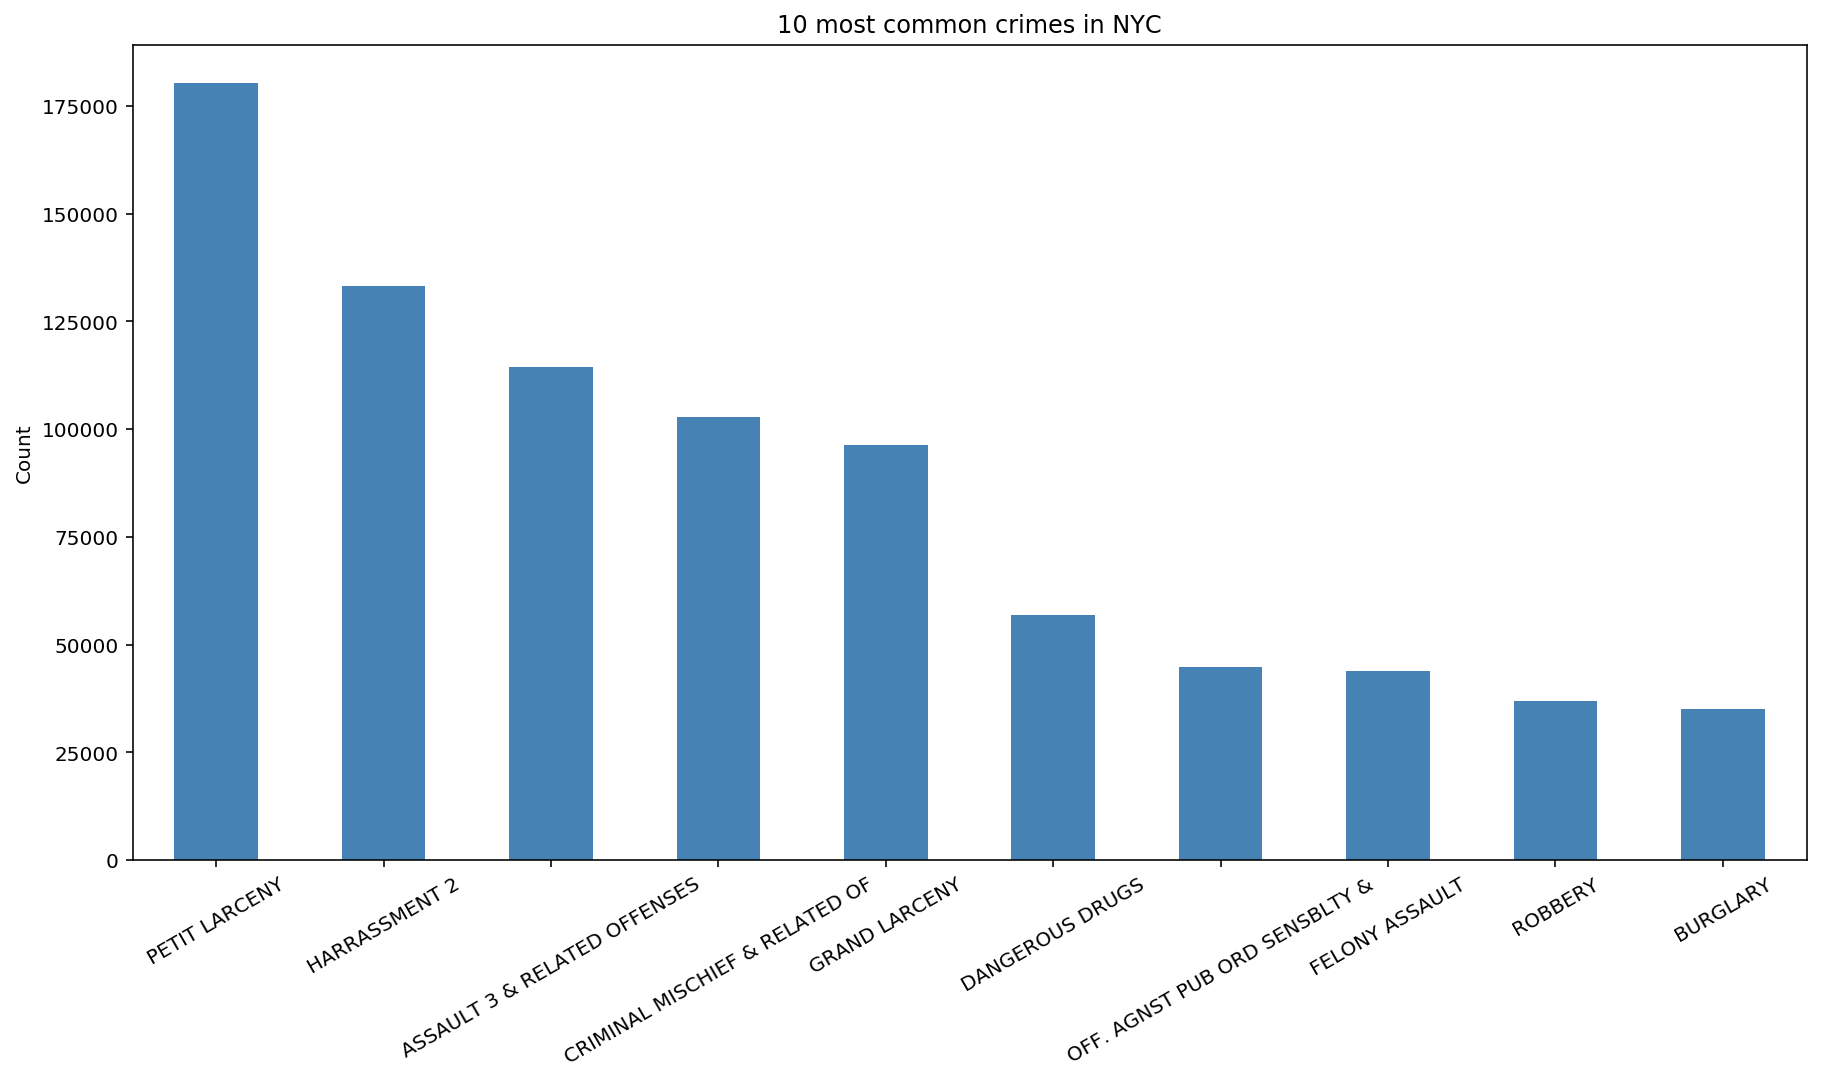

In [13]:
# set default figure size
plt.rcParams['figure.figsize'] = (15.0, 7.5)


# KY_CD is the three digit offense classification code
df['OFNS_DESC'].value_counts()[:10].plot.bar(color = 'steelblue',rot=30)
plt.ylabel('Count')
plt.title('10 most common crimes in NYC')
plt.show()
#df['OFNS_DESC'].value_counts()[:10]

#df['OFNS_DESC'].nunique() - 66




###### PETIT LARCENY  is the most frequent crime in NYC.

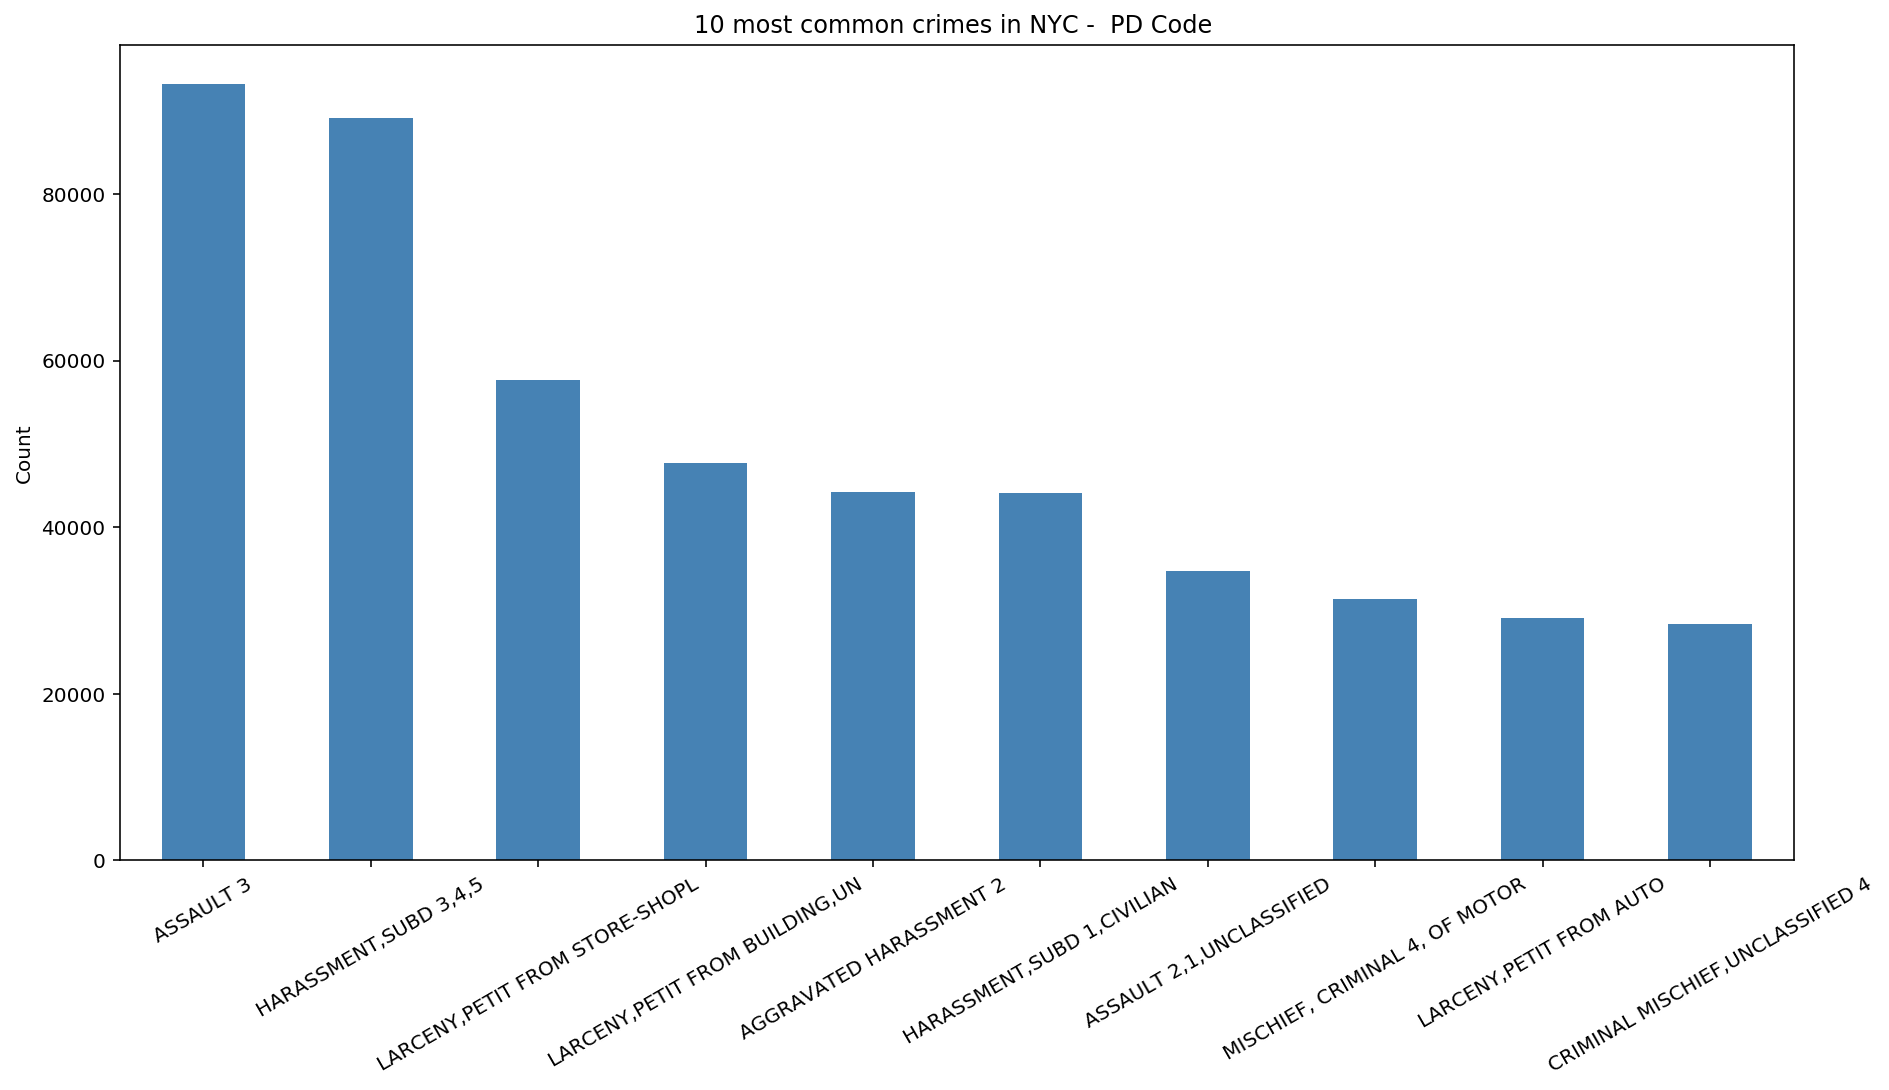

ASSAULT 3                           93214
HARASSMENT,SUBD 3,4,5               89064
LARCENY,PETIT FROM STORE-SHOPL      57638
LARCENY,PETIT FROM BUILDING,UN      47733
AGGRAVATED HARASSMENT 2             44246
HARASSMENT,SUBD 1,CIVILIAN          44116
ASSAULT 2,1,UNCLASSIFIED            34791
MISCHIEF, CRIMINAL 4, OF MOTOR      31401
LARCENY,PETIT FROM AUTO             29061
CRIMINAL MISCHIEF,UNCLASSIFIED 4    28411
Name: PD_DESC, dtype: int64

In [14]:

df['PD_DESC'].value_counts()[:10].plot.bar(color = 'steelblue',rot=30)

plt.ylabel('Count')
plt.title('10 most common crimes in NYC -  PD Code ')
plt.show()
df['PD_DESC'].value_counts()[:10]

##### PD code is more granular than key code (the previous visualization). According to PD code, ASSAULT 3  is the most common crime.

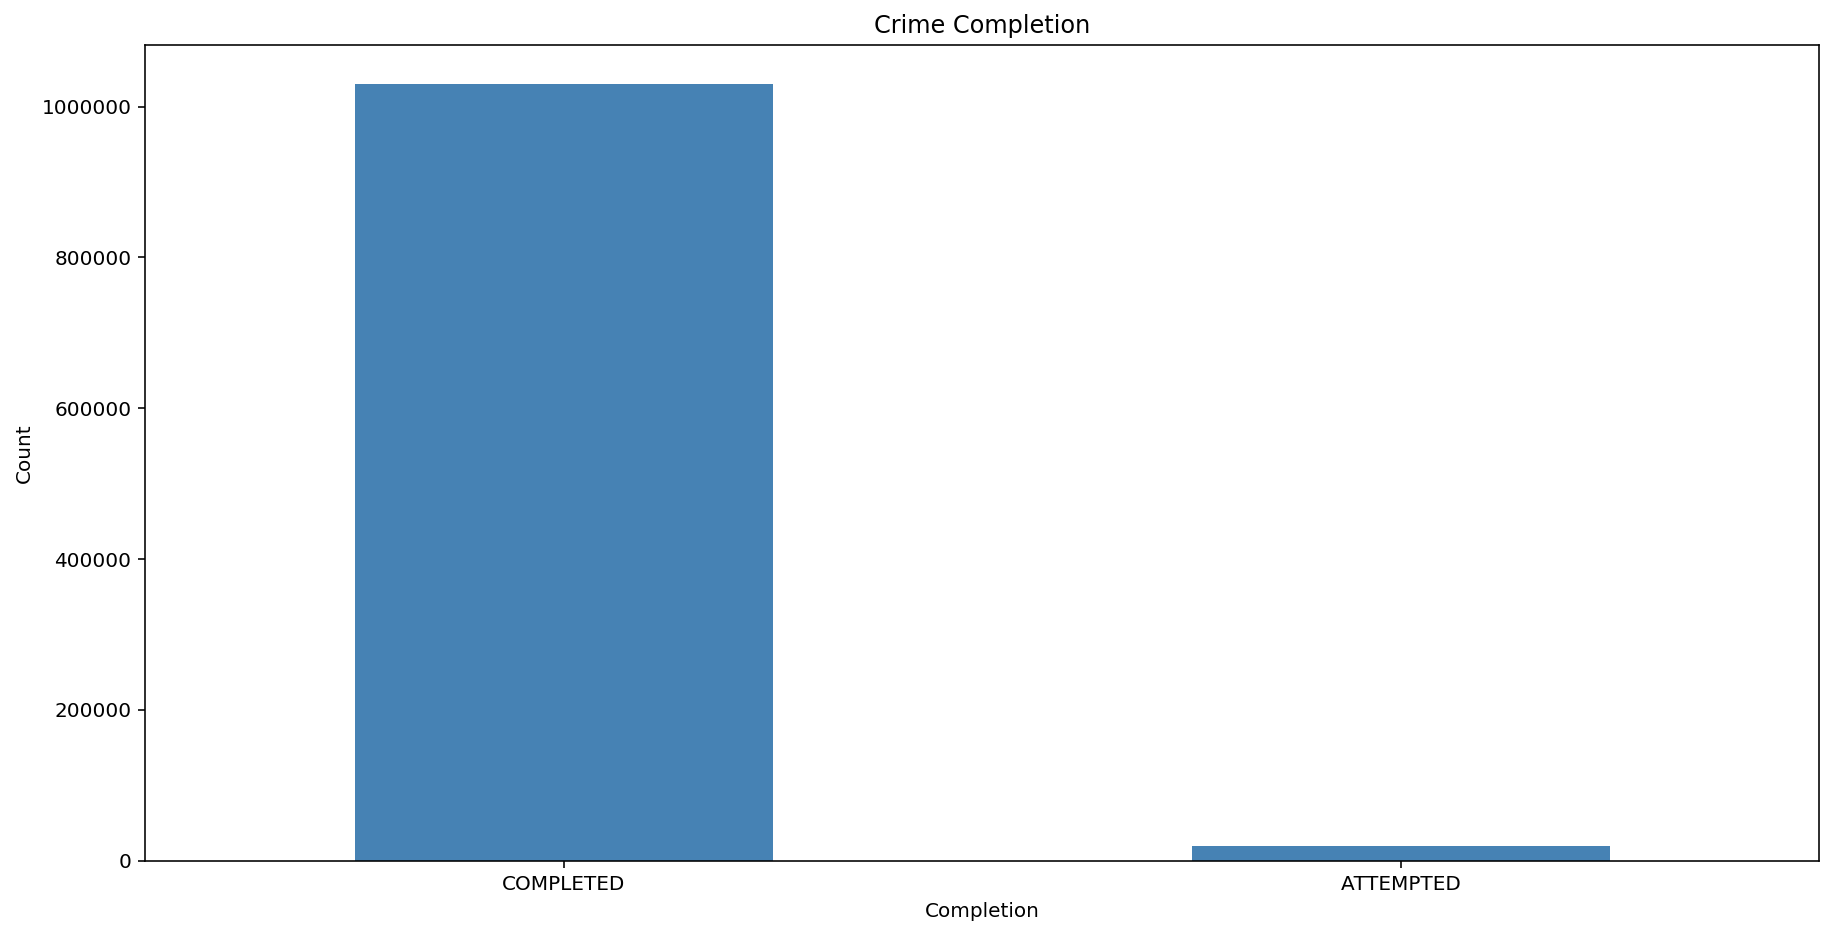

COMPLETED    1029816
ATTEMPTED    18758  
Name: CRM_ATPT_CPTD_CD, dtype: int64

In [15]:
plt.rcParams['figure.figsize'] = (15, 7.5)


df['CRM_ATPT_CPTD_CD'].value_counts()[:10].plot.bar(color = 'steelblue',rot=0)
plt.ylabel('Count')
plt.xlabel('Completion')

plt.title('Crime Completion')
plt.show()
df['CRM_ATPT_CPTD_CD'].value_counts()[:10]

In [16]:
1029816/(18758+1029816)

0.9821109430521833

##### 98.21% of the crime completed. 

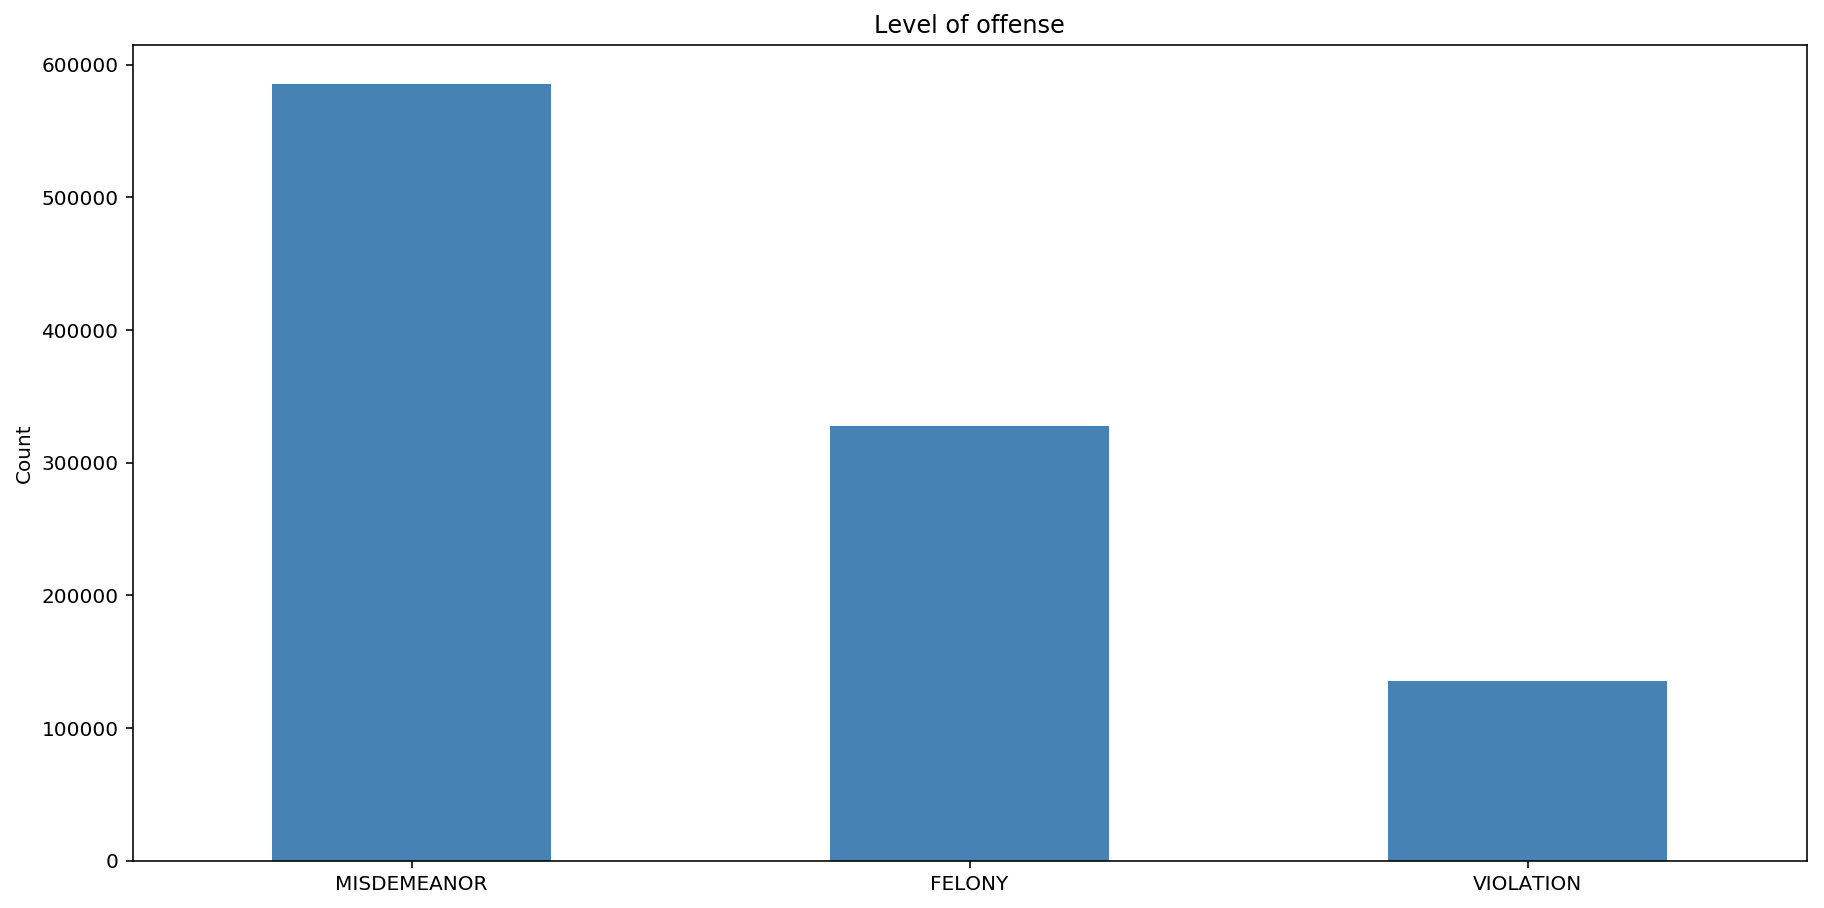

MISDEMEANOR    585468
FELONY         327807
VIOLATION      135300
Name: LAW_CAT_CD, dtype: int64

In [17]:
df['LAW_CAT_CD'].value_counts().plot.bar(color = 'steelblue',rot=0)
plt.ylabel('Count')
plt.title('Level of offense')
plt.show()
df['LAW_CAT_CD'].value_counts()

##### Most of the crimes are at the MISDEMEANOR level. 

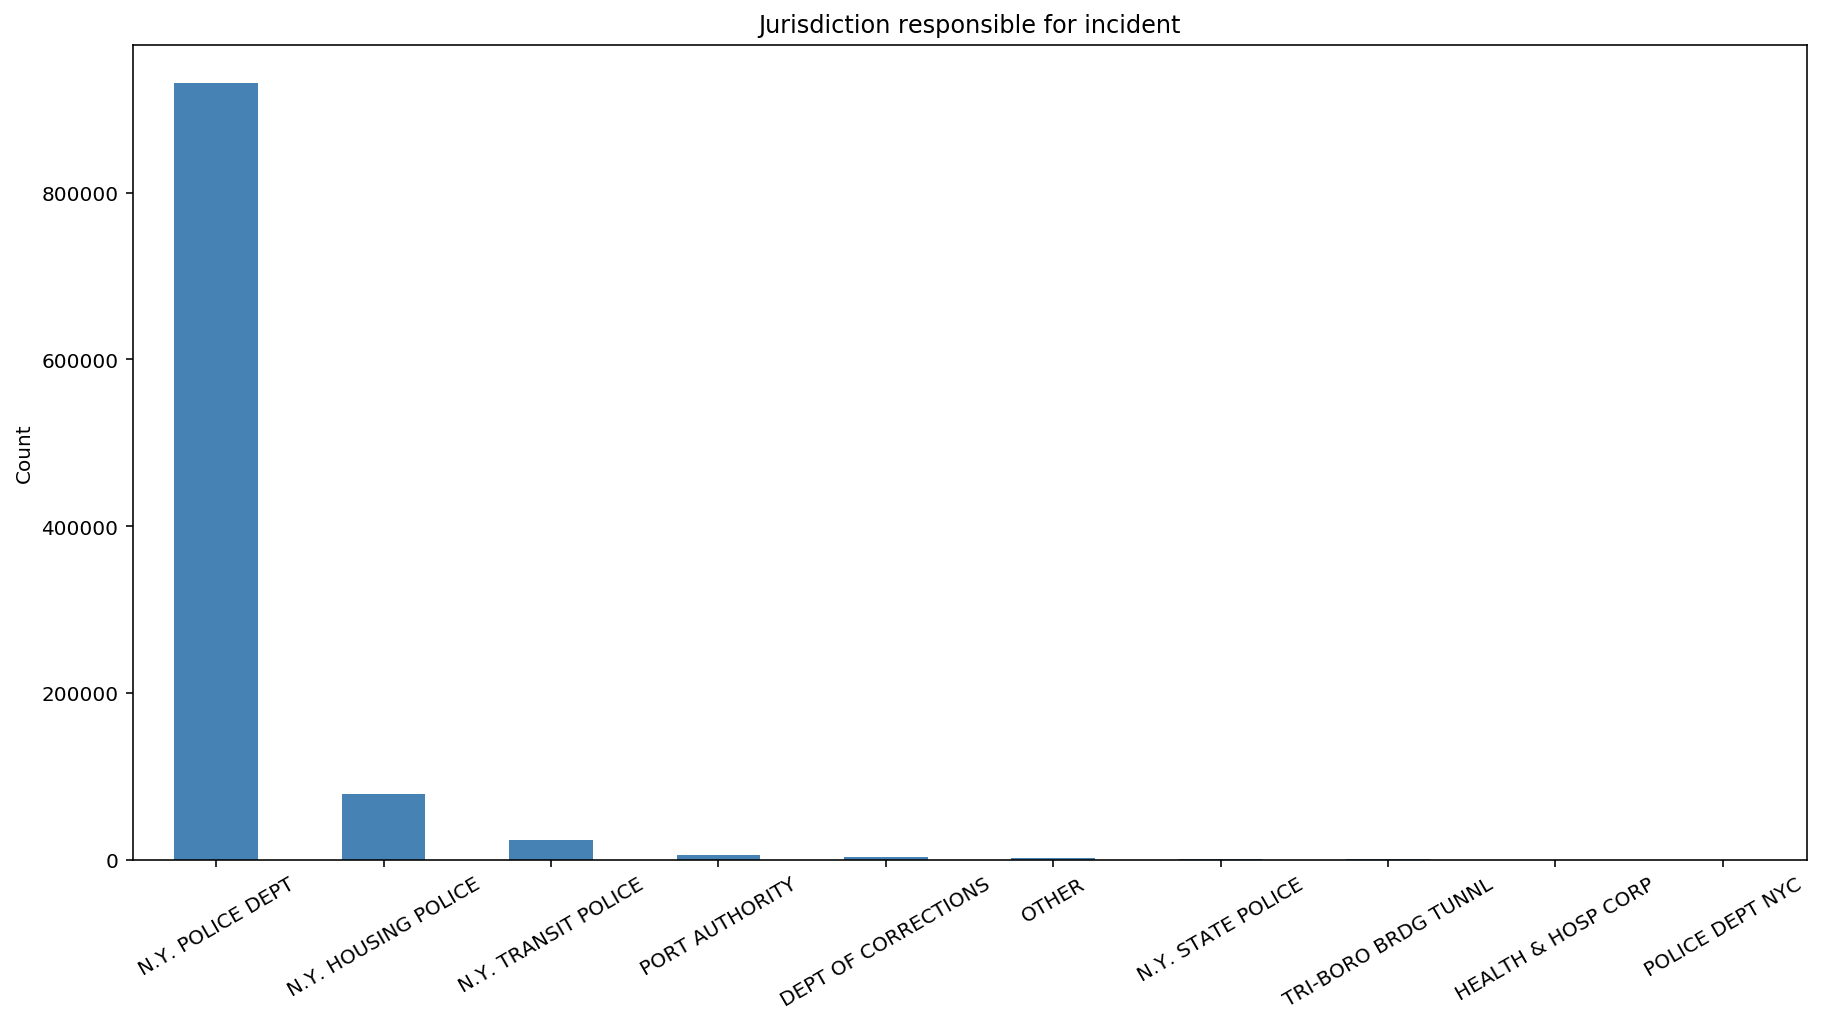

N.Y. POLICE DEPT       930995
N.Y. HOUSING POLICE    79474 
N.Y. TRANSIT POLICE    24120 
PORT AUTHORITY         5626  
DEPT OF CORRECTIONS    3086  
OTHER                  2840  
N.Y. STATE POLICE      678   
TRI-BORO BRDG TUNNL    592   
HEALTH & HOSP CORP     473   
POLICE DEPT NYC        158   
Name: JURIS_DESC, dtype: int64

In [18]:
df['JURIS_DESC'].value_counts()[:10].plot.bar(color = 'steelblue',rot=30)
plt.ylabel('Count')
plt.title('Jurisdiction responsible for incident')
plt.show()
df['JURIS_DESC'].value_counts()[:10]

##### Most crimes are handled by NYPD. 

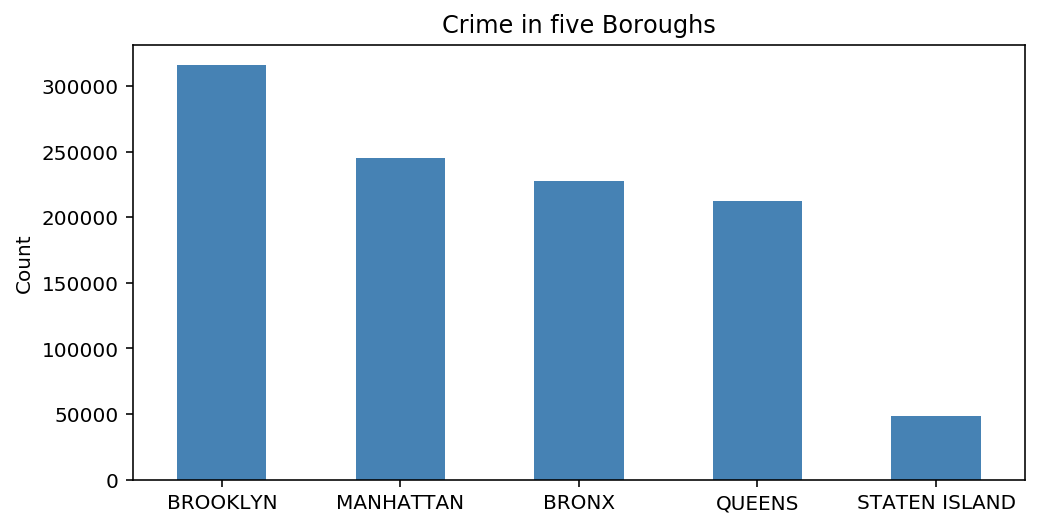

BROOKLYN         315648
MANHATTAN        244749
BRONX            227477
QUEENS           211958
STATEN ISLAND    48743 
Name: BORO_NM, dtype: int64

In [ ]:
plt.figure(figsize=(8,4))
df['BORO_NM'].value_counts().plot.bar(color = 'steelblue',rot=0)
plt.ylabel('Count')
plt.title('Crime in five Boroughs')
plt.show()
df['BORO_NM'].value_counts()

##### Most crimes happened in Brooklyn.

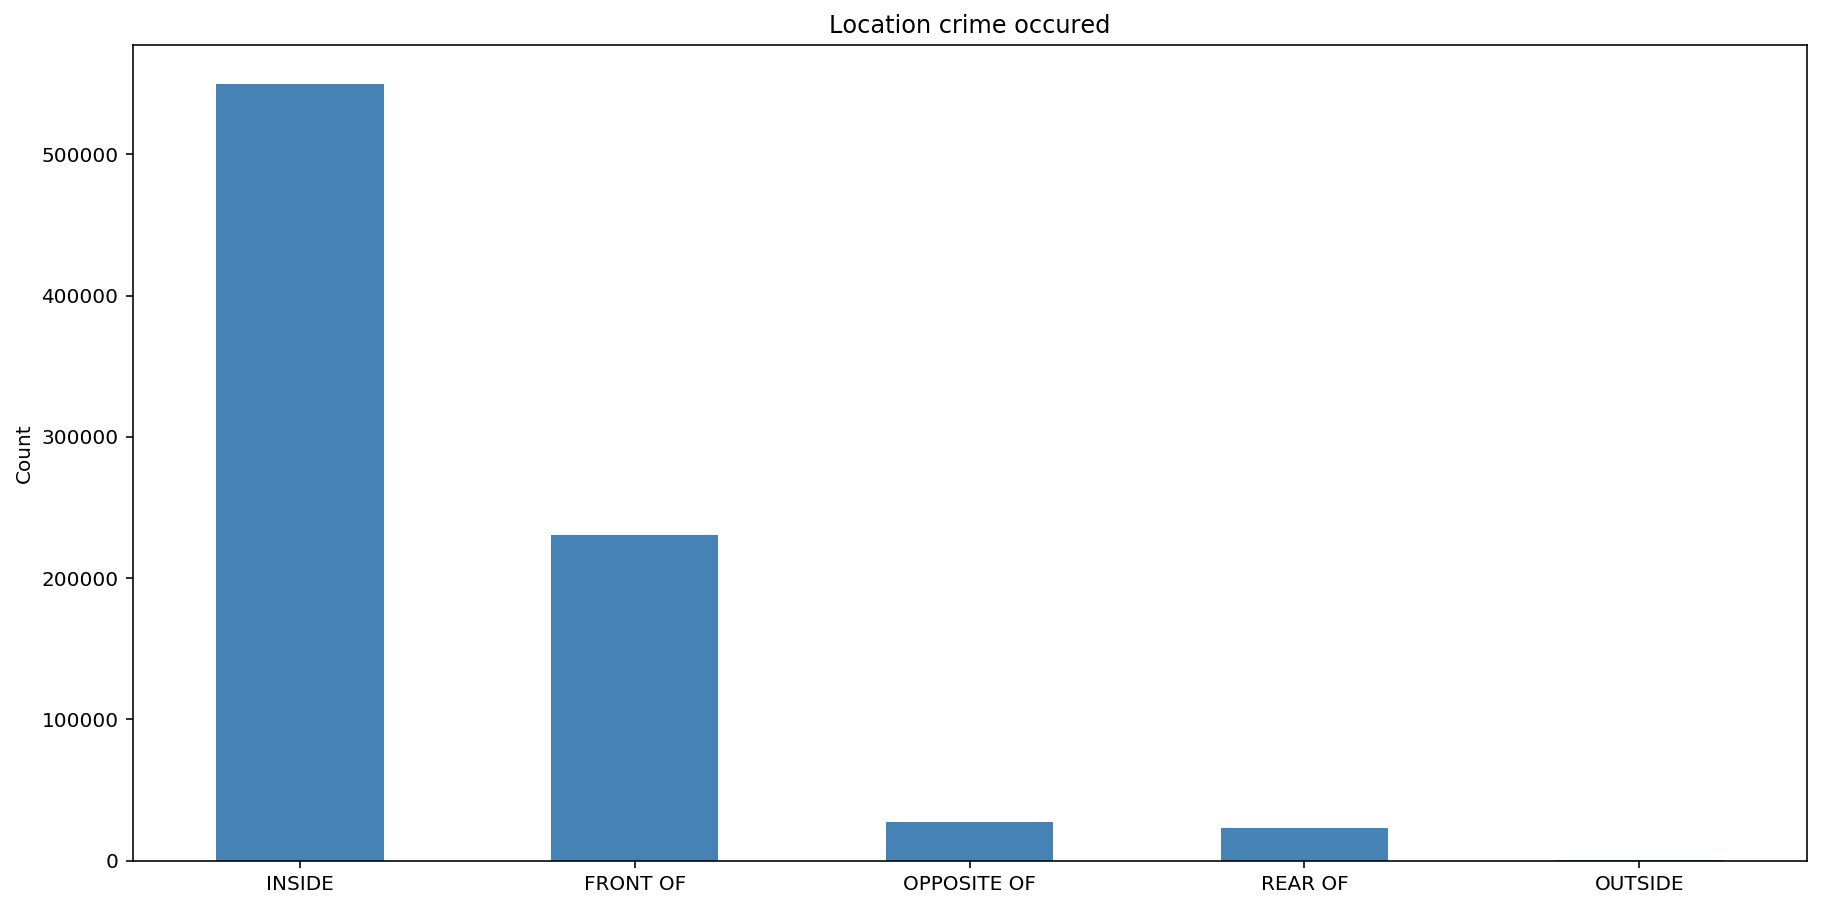

INSIDE         549718
FRONT OF       230557
OPPOSITE OF    27135 
REAR OF        22968 
OUTSIDE        445   
Name: LOC_OF_OCCUR_DESC, dtype: int64

In [ ]:
df['LOC_OF_OCCUR_DESC'].value_counts().plot.bar(color = 'steelblue',rot=0)
plt.ylabel('Count')
plt.title('Location crime occured')
plt.show()
df['LOC_OF_OCCUR_DESC'].value_counts()

##### Most crimes happened inside premises.

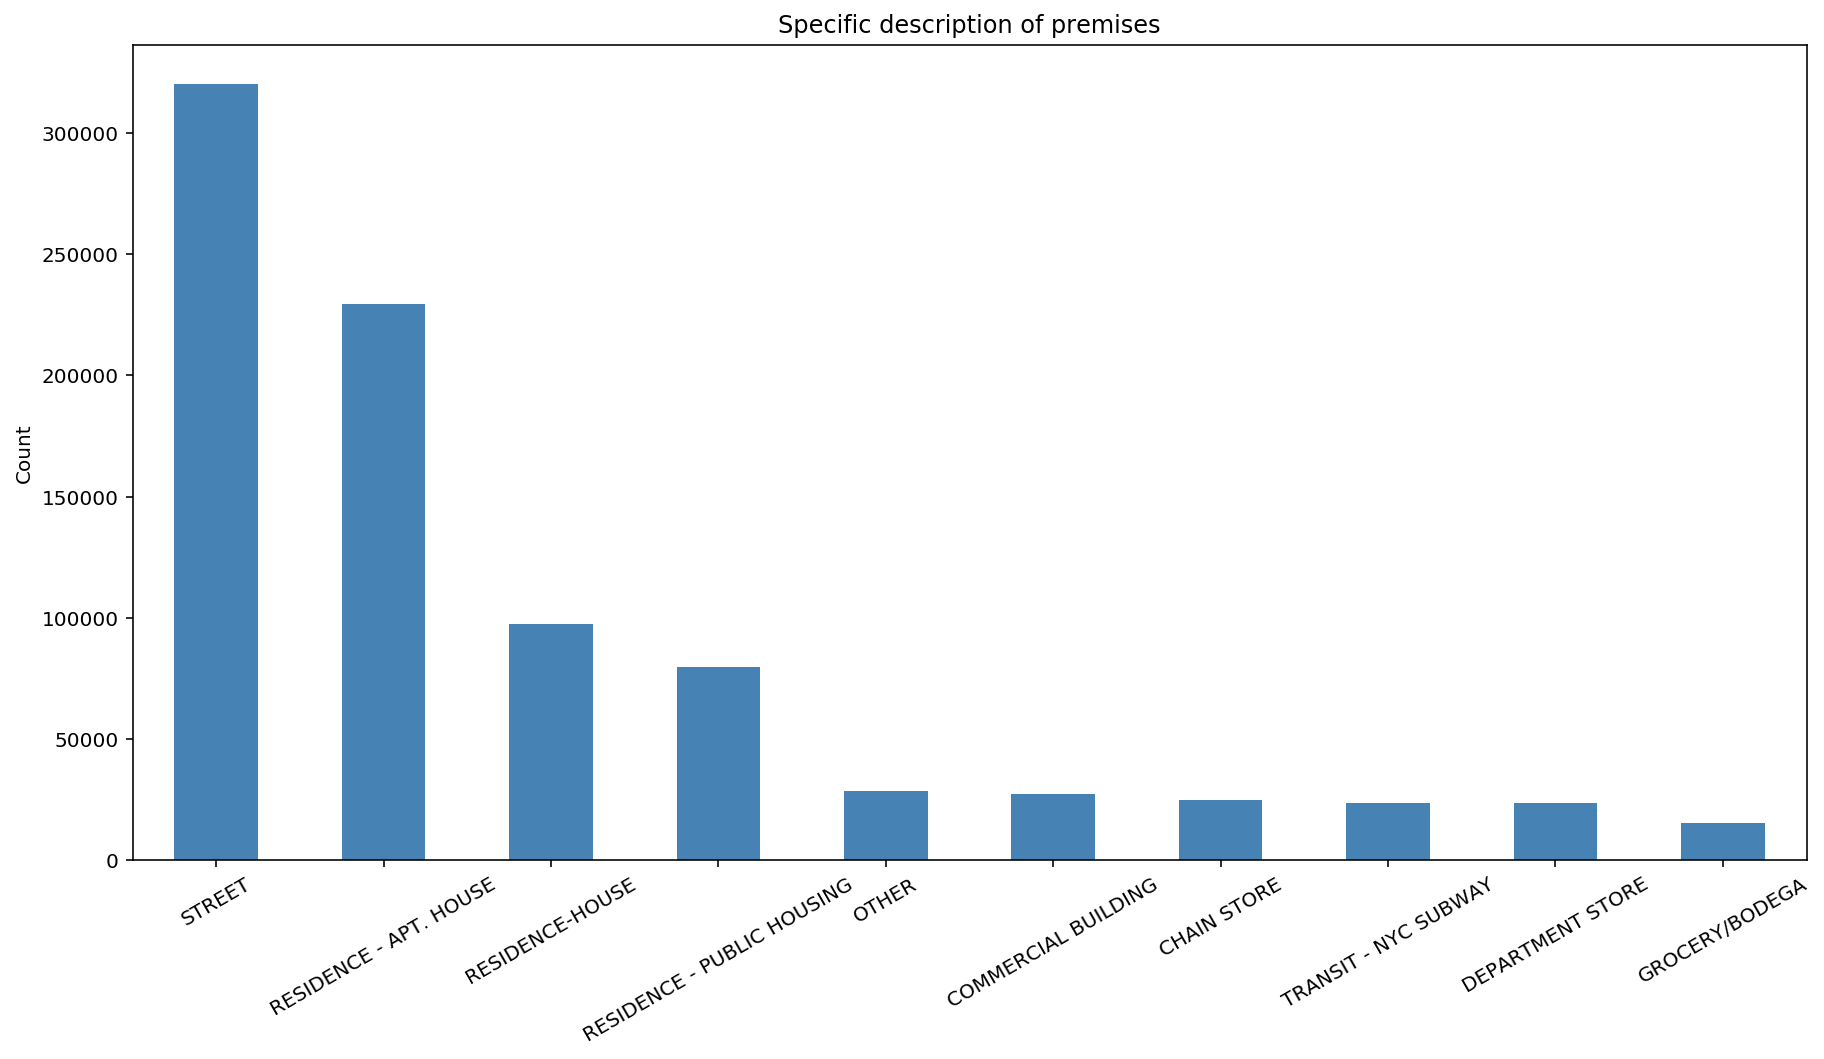

STREET                        320261
RESIDENCE - APT. HOUSE        229490
RESIDENCE-HOUSE               97446 
RESIDENCE - PUBLIC HOUSING    79577 
OTHER                         28726 
COMMERCIAL BUILDING           27212 
CHAIN STORE                   24761 
TRANSIT - NYC SUBWAY          23860 
DEPARTMENT STORE              23682 
GROCERY/BODEGA                15377 
Name: PREM_TYP_DESC, dtype: int64

In [ ]:
df['PREM_TYP_DESC'].value_counts()[:10].plot.bar(color = 'steelblue',rot=30)
plt.ylabel('Count')
plt.title('Specific description of premises')
plt.show()
df['PREM_TYP_DESC'].value_counts()[:10]

##### Most crimes happened on street.

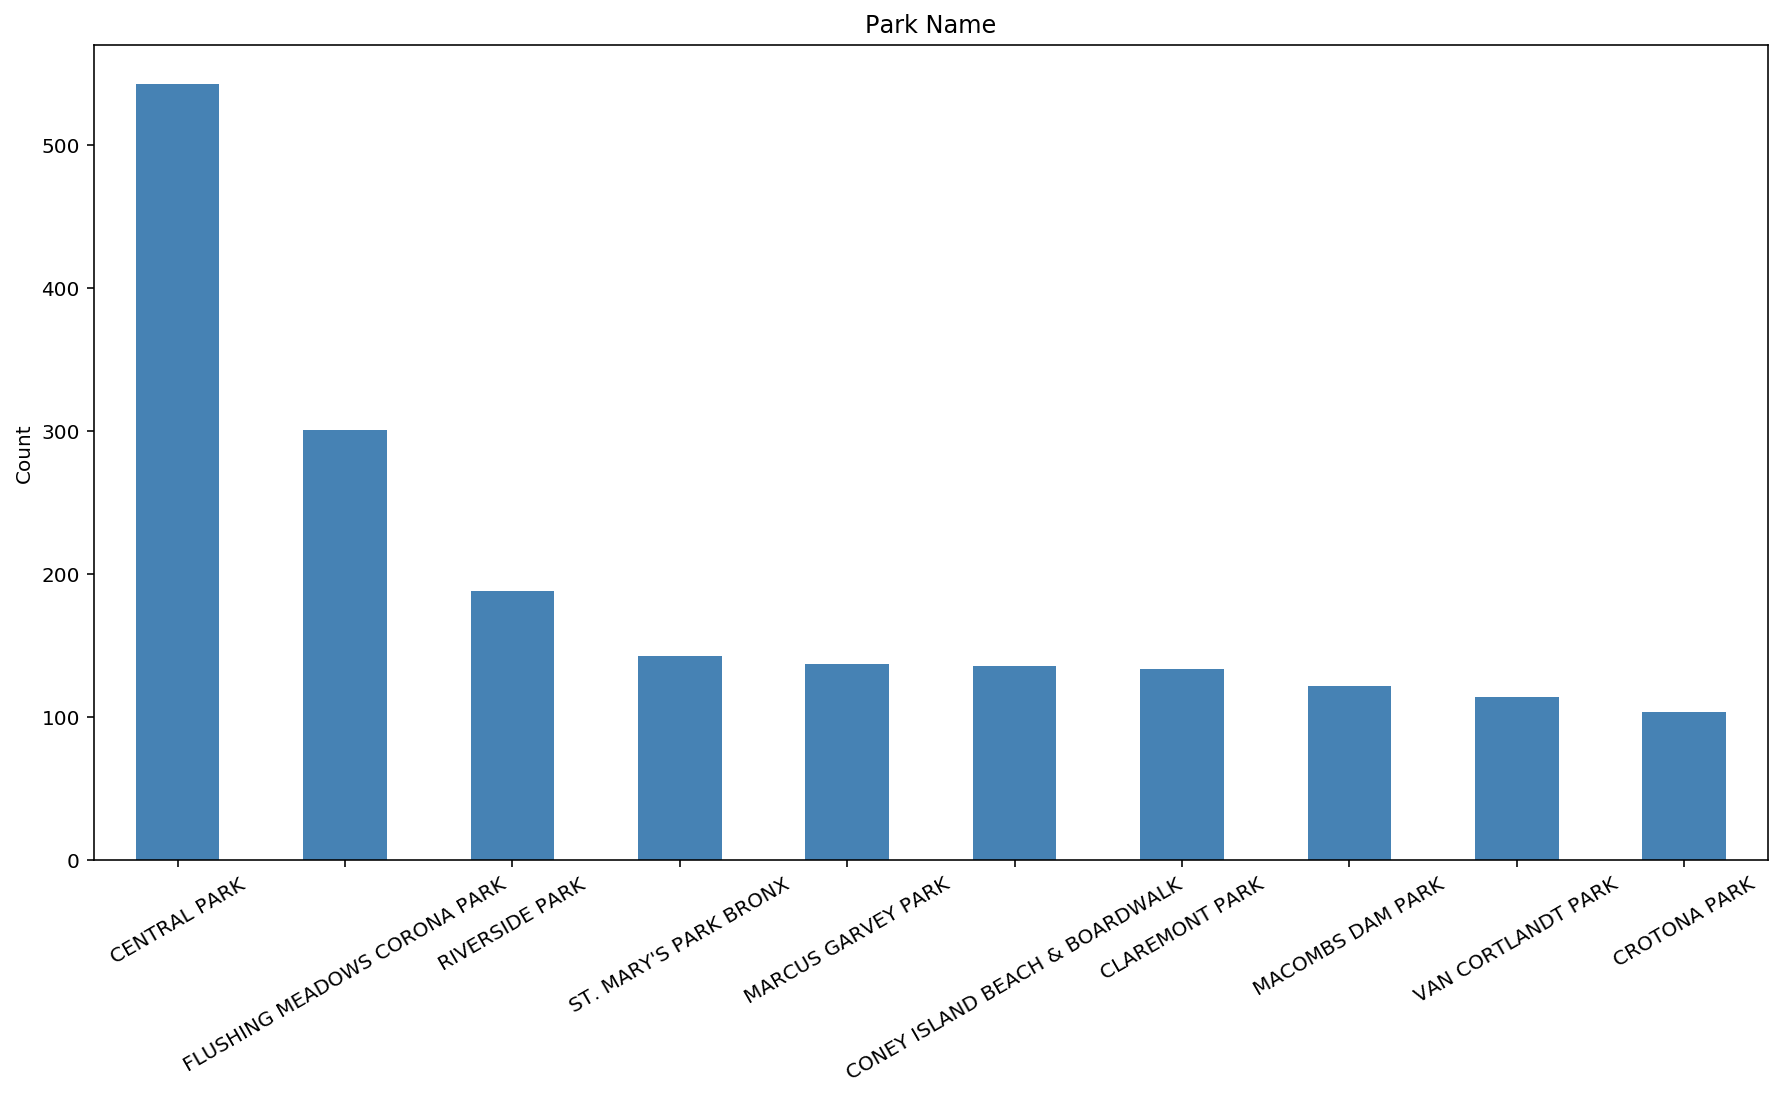

CENTRAL PARK                      543
FLUSHING MEADOWS CORONA PARK      301
RIVERSIDE PARK                    188
ST. MARY'S PARK BRONX             143
MARCUS GARVEY PARK                137
CONEY ISLAND BEACH & BOARDWALK    136
CLAREMONT PARK                    134
MACOMBS DAM PARK                  122
VAN CORTLANDT PARK                114
CROTONA PARK                      104
Name: PARKS_NM, dtype: int64

In [ ]:
df['PARKS_NM'].value_counts()[:10].plot.bar(color = 'steelblue',rot=30)
plt.ylabel('Count')
plt.title('Park Name')
plt.show()
df['PARKS_NM'].value_counts()[:10]

##### Among all the parks in NYC,  central park is the most dangerous one.

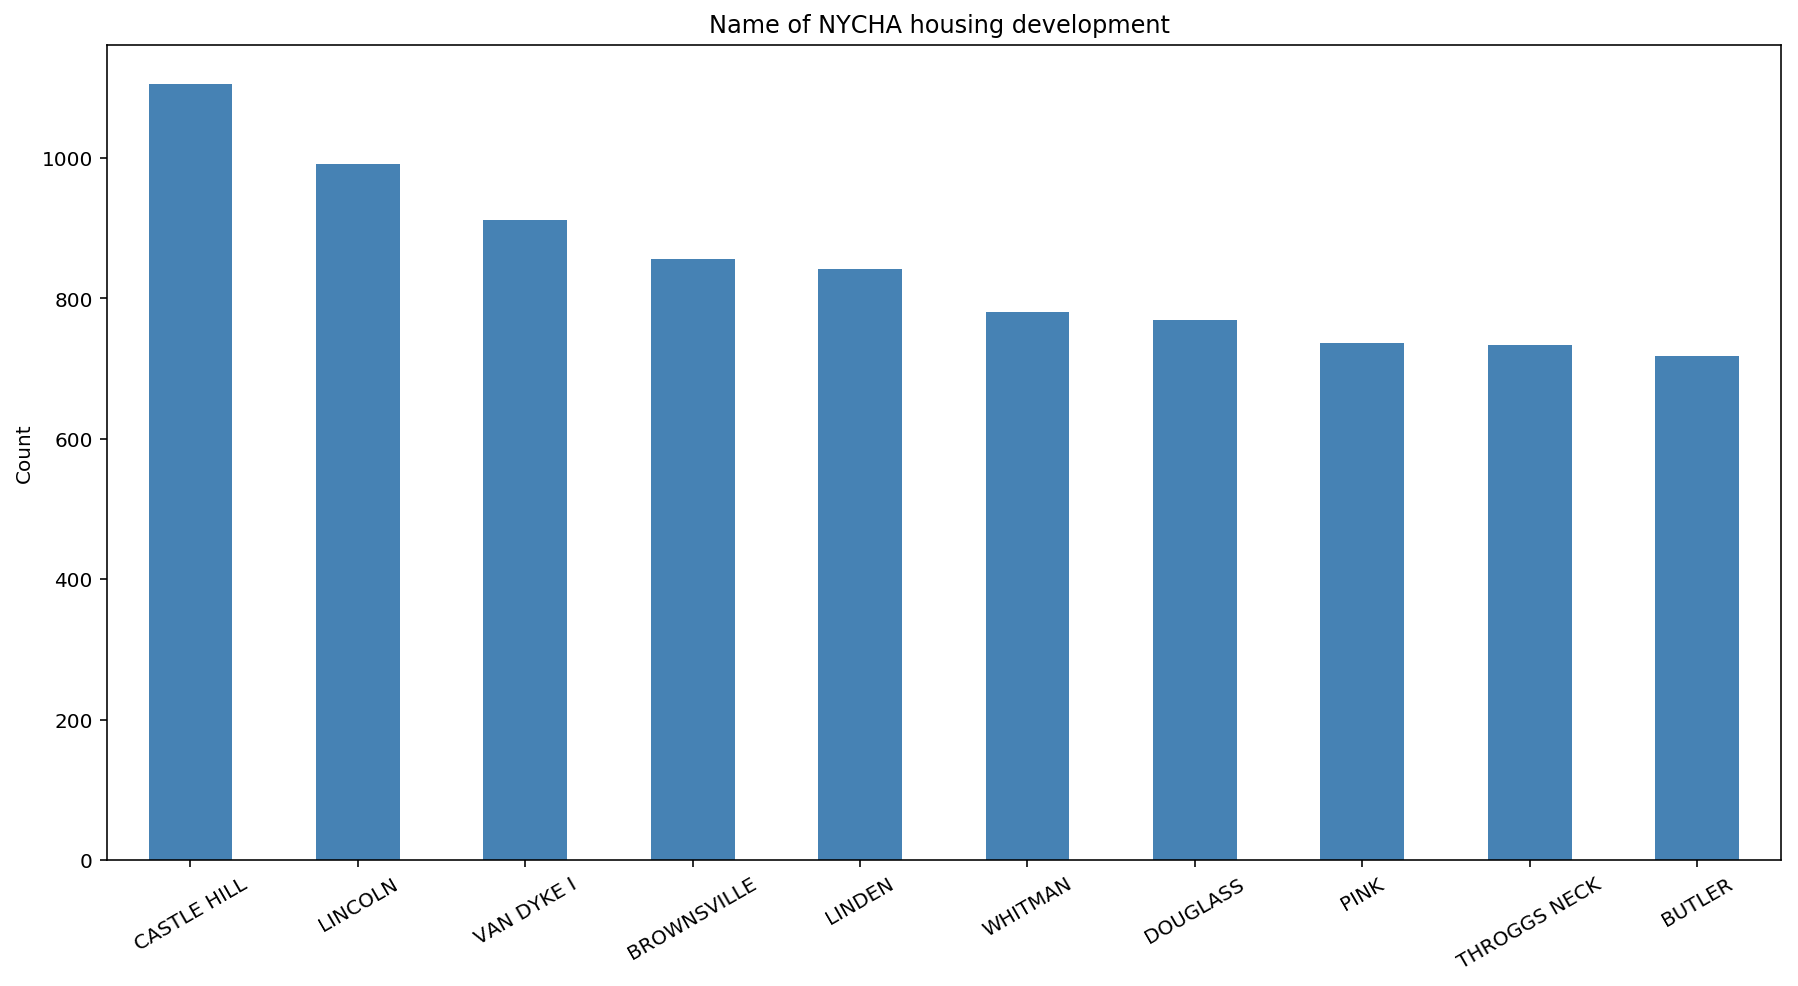

CASTLE HILL     1106
LINCOLN         992 
VAN DYKE I      912 
BROWNSVILLE     856 
LINDEN          842 
WHITMAN         781 
DOUGLASS        769 
PINK            736 
THROGGS NECK    734 
BUTLER          718 
Name: HADEVELOPT, dtype: int64

In [ ]:
df['HADEVELOPT'].value_counts()[:10].plot.bar(color = 'steelblue',rot=30)
plt.ylabel('Count')
plt.title('Name of NYCHA housing development ')
plt.show()
df['HADEVELOPT'].value_counts()[:10]

##### Among all the NYCHA housing,  CASTLE HILL has the largest crime amount. 

### 2.3 Crime time

In [ ]:
df['CMPLNT_FR_DT'].describe()

count     1048510 
unique    2510    
top       1/1/2014
freq      2211    
Name: CMPLNT_FR_DT, dtype: object

##### New Year's Day is the day has the largest crime amount,  2211 cases in a day,  along the entire year.

### 2.4 Lantitude&Longtitude

#### 2.4.1 Neighborhood Mapping Function

In [3]:
def append_neighborhood(df, geo_df):
    # Create a list of Point objects
    point_list = []
    for idx, biz in df.iterrows():
        point_list.append(Point(biz["Longitude"], biz["Latitude"]))
    
    # Create a list of Polygon
    polygon_list = list(geo_df["geometry"])
    
    neighborhood_list = []
    neighborhood_group_list = []
    flag = True
    for i, point in enumerate(point_list):
        print(i, end='\r', flush=True)
        for j, polygon in enumerate(polygon_list):
            if point.within(polygon):
                neighborhood_list.append(neighbourhoods_geo.iloc[j][0])
                neighborhood_group_list.append(neighbourhoods_geo.iloc[j][1])
                break
            if j == len(polygon_list) - 1:
                neighborhood_list.append(None)
                neighborhood_group_list.append(None)
    
    df["neighborhood"] = neighborhood_list
    df["neighborhood_group"] = neighborhood_group_list
    df = df[~df["neighborhood"].isna()]
    return df

In [4]:
# add neighborhood column according to the longitude and latitude 
df = append_neighborhood(df, neighbourhoods_geo)

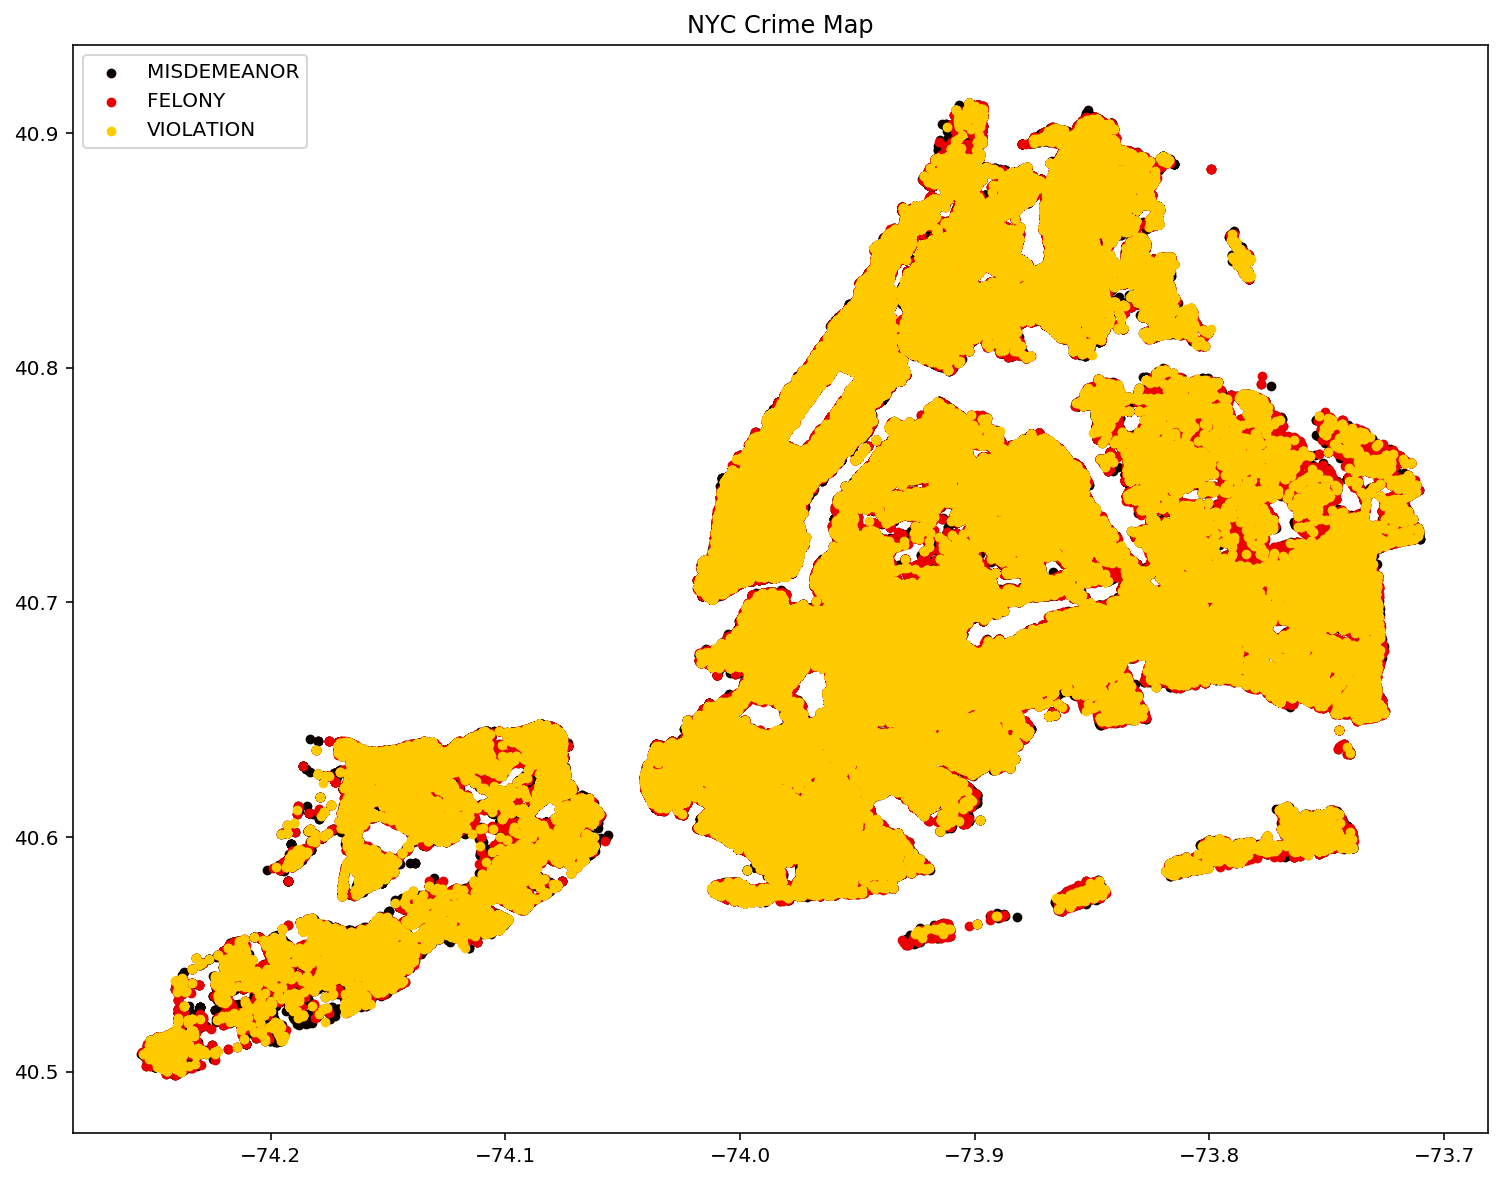

In [5]:
plt.figure(figsize=(20,10))

#Scatter of Petal
x=df['Longitude']
y=df['Latitude']

# Get unique names of complaint types
uniq = list(set(df['LAW_CAT_CD']))

# Set the color map to match the number of species
z = range(1,len(uniq))
hot = plt.get_cmap('hot')
cNorm  = colors.Normalize(vmin=0, vmax=len(uniq))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)

# Plot each species
for i in range(len(uniq)):
    indx = df['LAW_CAT_CD'] == uniq[i]
    plt.scatter(x[indx], y[indx], s=15, color=scalarMap.to_rgba(i), label=uniq[i])
    
# set to actual scale 
plt.gca().set_aspect('equal', adjustable='box')
plt.title('NYC Crime Map')
plt.legend(loc='upper left')
plt.show()

## 3 Feature relations with neightborhood
### 3.1 Count

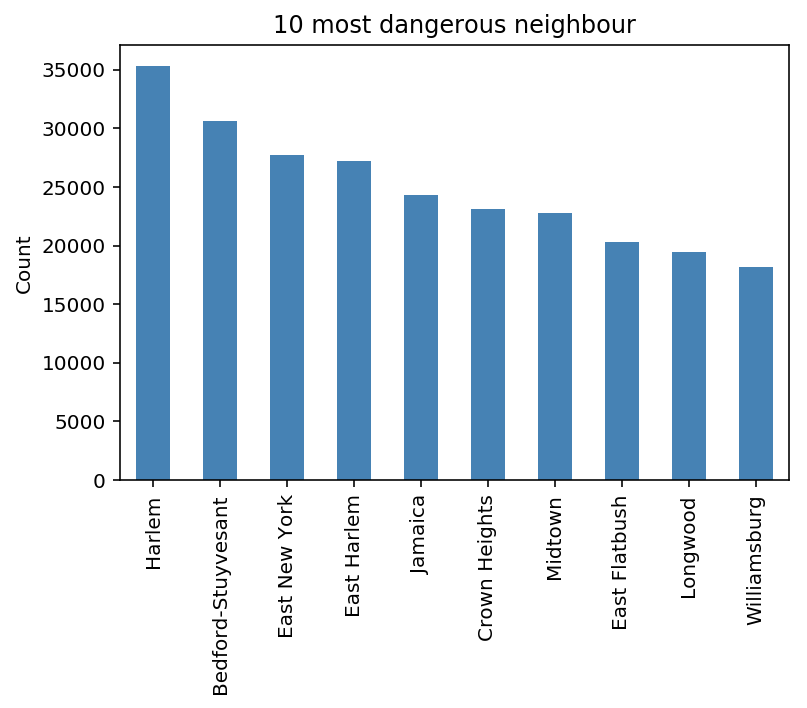

Harlem                35314
Bedford-Stuyvesant    30660
East New York         27685
East Harlem           27177
Jamaica               24287
Crown Heights         23115
Midtown               22784
East Flatbush         20265
Longwood              19414
Williamsburg          18168
Name: neighborhood, dtype: int64

In [7]:
df['neighborhood'].value_counts()[:10].plot.bar(color = 'steelblue')
plt.ylabel('Count')
plt.title('10 most dangerous neighbour')
plt.show()
df['neighborhood'].value_counts()[:10]

##### Herlem is the neighborhood has most crime. 

###  3.2 Density¶


In [ ]:
density_df = df.groupby(["neighborhood"]).agg({"CMPLNT_NUM": "count"}) \
    .join(neighbourhoods_nyc.set_index("neighbourhood"), on="neighborhood")
density_df['density'] = density_df["CMPLNT_NUM"] / density_df["area"]
density.sort_values(ascending=False)[1:11].plot.bar()

In [15]:
safety_count = df.groupby(["neighborhood"]).agg({"CMPLNT_NUM": "count"}).rename(columns={'CMPLNT_NUM': 'count'})
safety_count

,count
neighborhood,
Allerton,5361
Arden Heights,891
Arrochar,1218
Arverne,2158
Astoria,9216
Bath Beach,2894
Battery Park City,525
Bay Ridge,5085
Bay Terrace,590


In [19]:
safety = pd.read_csv('safety_count.csv')
safety

,Unnamed: 0,neighbourhood,count
0,0,Bayswater,1708
1,1,Allerton,5361
2,2,City Island,354
3,3,Ditmars Steinway,3535
4,4,Ozone Park,5665
5,5,Fordham,16332
6,6,Whitestone,1582
7,7,Arden Heights,891
8,8,Arrochar,1218
9,9,Arverne,2158


In [18]:
df3 = df.groupby('neighborhood')['LAW_CAT_CD'].value_counts().unstack().fillna(0)
pd.DataFrame(df3)
df3

LAW_CAT_CD,FELONY,MISDEMEANOR,VIOLATION
neighborhood,,,
Allerton,1230.0,3435.0,696.0
Arden Heights,206.0,470.0,215.0
Arrochar,253.0,674.0,291.0
Arverne,770.0,1012.0,376.0
Astoria,2746.0,5132.0,1338.0
Bath Beach,826.0,1659.0,409.0
Battery Park City,166.0,277.0,82.0
Bay Ridge,1355.0,2997.0,733.0
Bay Terrace,223.0,244.0,123.0


In [20]:
safety_output = pd.merge(safety, df3, how='left', left_on=['neighbourhood'], right_on=['neighborhood'])
safety_output = safety_output.drop(columns = ['Unnamed: 0'])
safety_output = safety_output.rename(columns={'safety_count': 'count'})
safety_output.fillna(0)
safety_output

,neighbourhood,count,FELONY,MISDEMEANOR,VIOLATION
0,Bayswater,1708,621.0,790.0,297.0
1,Allerton,5361,1230.0,3435.0,696.0
2,City Island,354,88.0,205.0,61.0
3,Ditmars Steinway,3535,1045.0,1969.0,521.0
4,Ozone Park,5665,1986.0,2926.0,753.0
5,Fordham,16332,4674.0,9749.0,1909.0
6,Whitestone,1582,569.0,731.0,282.0
7,Arden Heights,891,206.0,470.0,215.0
8,Arrochar,1218,253.0,674.0,291.0
9,Arverne,2158,770.0,1012.0,376.0


In [21]:
safety_output.to_csv('safety_level_of_offense_count.csv',encoding='utf-8', index=False)
